### Import Libraries 

In [30]:
import pickle
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
import warnings
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Dropout
from scikeras.wrappers  import KerasRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
sns.set_style(style='whitegrid')
%matplotlib inline 
warnings.filterwarnings('ignore')

### Load Transformed Data

In [32]:
df = pd.read_csv('../data/transformed_data.csv')
df.head()

,Unnamed: 0,price,production_year,mileage,fuel_type,mark,model,fiscal_power
0,0,135000,2013.0,169999,Diesel,Peugeot,508,6
1,1,53000,2008.0,39999,Diesel,Renault,Clio,6
2,2,59000,2007.0,189999,Diesel,Citroen,C3,6
3,3,88000,2010.0,39999,Diesel,Mercedes-Benz,220,6
4,4,60000,2009.0,139999,Essence,Ford,Fiesta,7


### Building Regression Models 

##### 1. Encoding and Scaling Data 

Before getting to modeling section. After taking a quick look at the available data types. We notice that we have some categorical columns such as fuel_type, mark , and model. So we're going to convert them to numrical values using the get dummies function from pandas before feeding these features to Machine learning Models. 

In [82]:
# Converting category labels into numerical using LabelEncoder
y = df.price
logy = df.log_price
#define the independent variables 
X = df.drop(['price','log_price'],axis=1)
encoder = LabelEncoder()
#get the categorical columns 
cat_cols = list(X.select_dtypes(include=['object']))
for col in cat_cols:
    try:
        X[col] = encoder.fit_transform(X[col])
    except:
        print('Error encoding '+col)

#show the dataframe 
X.head()

,production_year,mileage,fuel_type,mark,model,fiscal_power
0,2013.0,169999,0,37,62,6
1,2008.0,39999,0,40,168,6
2,2007.0,189999,0,11,121,6
3,2010.0,39999,0,33,25,6
4,2009.0,139999,1,17,205,7


In [83]:
# Data scaling
scaler = StandardScaler()
# Fit the scaler on training data 
scaler.fit(X) 
# Transform 
X_scaled = scaler.transform(X)
#show 
X_scaled

array([[ 0.89072187,  0.49318834, -0.61988582,  0.57462009, -1.26952865,
        -0.38324771],
       [ 0.09779682, -1.0619042 , -0.61988582,  0.78998114, -0.44046666,
        -0.38324771],
       [-0.06078819,  0.73243335, -0.61988582, -1.29184237, -0.80806962,
        -0.38324771],
       ...,
       [ 1.36647691, -1.3011492 , -0.61988582, -0.43039816, -1.09745918,
        -0.38324771],
       [ 1.04930688, -0.70303669, -0.61988582, -1.29184237, -0.80806962,
        -0.38324771],
       [-0.21937321, -0.88247044, -0.61988582,  0.57462009, -0.87846168,
        -0.38324771]])

In [84]:
from sklearn.model_selection import train_test_split
# now we use the train_test_split function already available in sklearn library to split our data set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, logy, test_size = 0.2, random_state =34)

##### 2. Linear Regression Model

In [36]:
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
lr = LinearRegression()
lr.fit(X_train, y_train)
#predict 
lr_preds = lr.predict(X_test)
# compute the residuals 
lr_residuals = y_test - lr_preds
# get the error 
lr_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lr_preds)))
lr_r2 = r2_score(y_test, lr_preds)
lr_mape = MAPE(np.exp(y_test),np.exp(lr_preds))
print('RMSE: %.2f'% lr_rmse)
print('R2 Score: %.2f' % lr_r2)
print('MAPE:%.2f' % lr_mape)
# Values without log transformation 
#R2 = 0.57 
#RMSE = 63933.52 
#show the coeffecients and their variables 
coef_dict = {}
for coef, feat in zip(lr.coef_,X.columns):
    coef_dict[feat] = round(coef,3)
print(f'Coefficients of the model: {coef_dict}')
print(f'Intercept: {round(lr.intercept_,2)}')

RMSE: 63972.54
R2 Score: 0.57
MAPE:31.64
Coefficients of the model: {'production_year': 0.389, 'fuel_type': -0.214, 'mark': 0.059, 'model': -0.013, 'fiscal_power': 0.124}
Intercept: 11.26


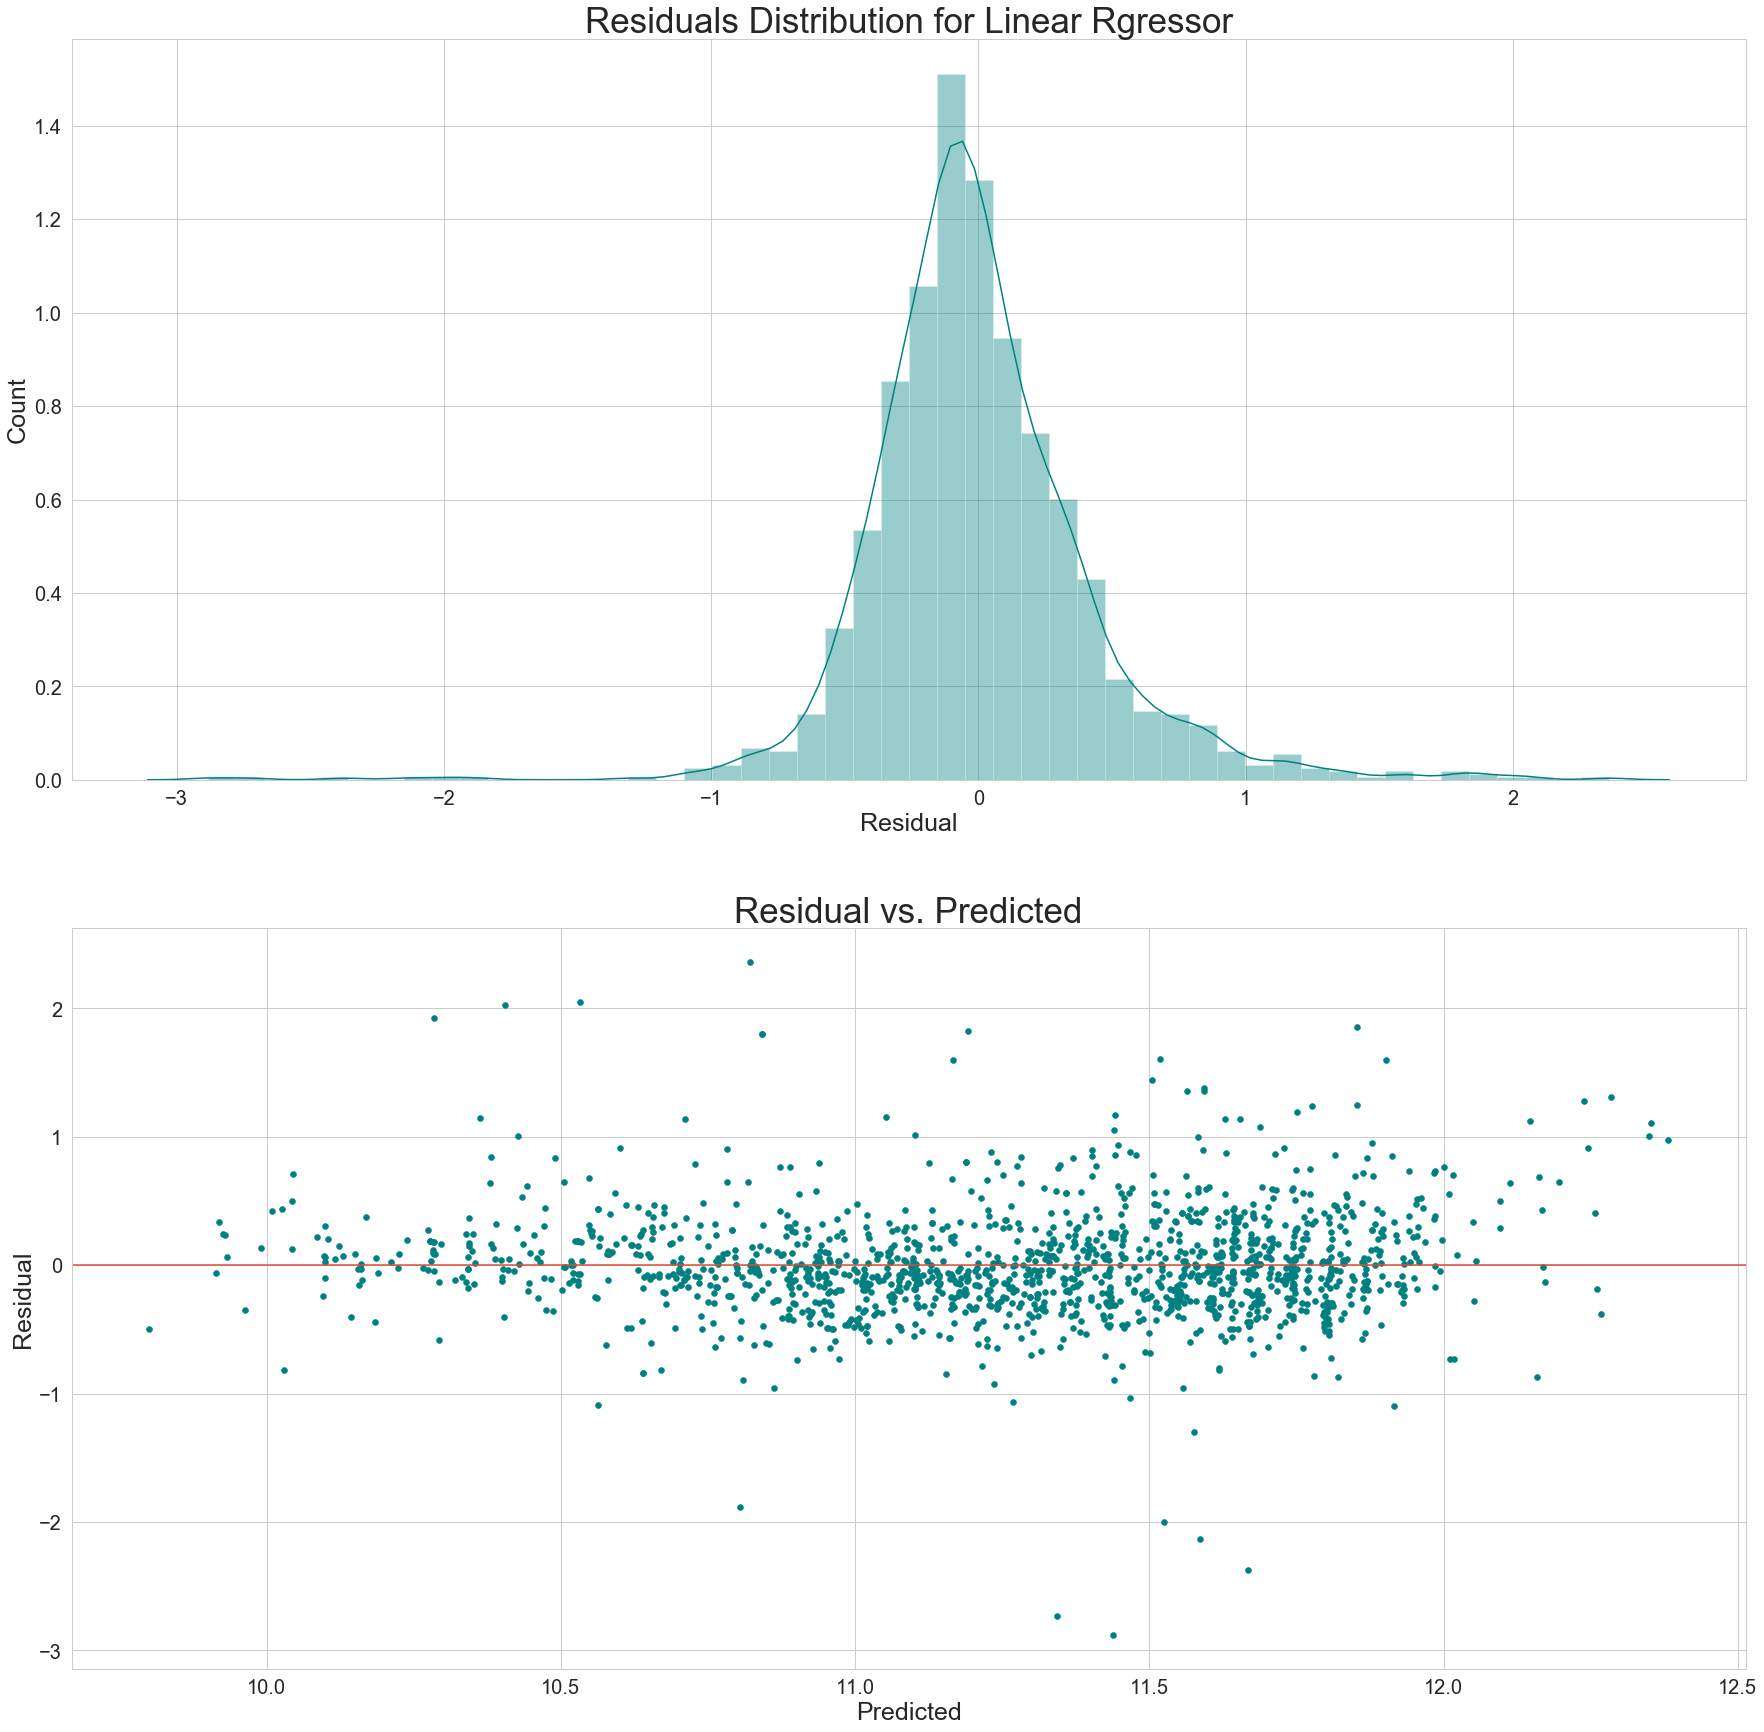

In [107]:
# plot the residuals
sb.set_style('whitegrid')
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sb.distplot(lr_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residuals Distribution for Linear Rgressor',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)
#residuals vs predicted
ax2 = plt.subplot(212)
plt.scatter(lr_preds, lr_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
plt.show()

##### 3. KNN Regressor Model

In [37]:
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = KNeighborsRegressor(n_neighbors=10,weights='uniform')
knn.fit(X_train, y_train)
#predict 
knn_preds = knn.predict(X_test)
# compute the residuals 
knn_residuals = y_test - knn_preds
# get the error 
knn_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(knn_preds)))
knn_r2 = r2_score(y_test, knn_preds)
knn_mape = MAPE(np.exp(y_test),np.exp(knn_preds))
print('RMSE: %.2f'% knn_rmse)
print('R2 Score: %.2f' % knn_r2 )
print('MAPE:%.2f' % knn_mape)
#values without log transformation 
##R2 = 0.57  
#RMSE = 51690.95 

RMSE: 51039.20
R2 Score: 0.71
MAPE:24.21


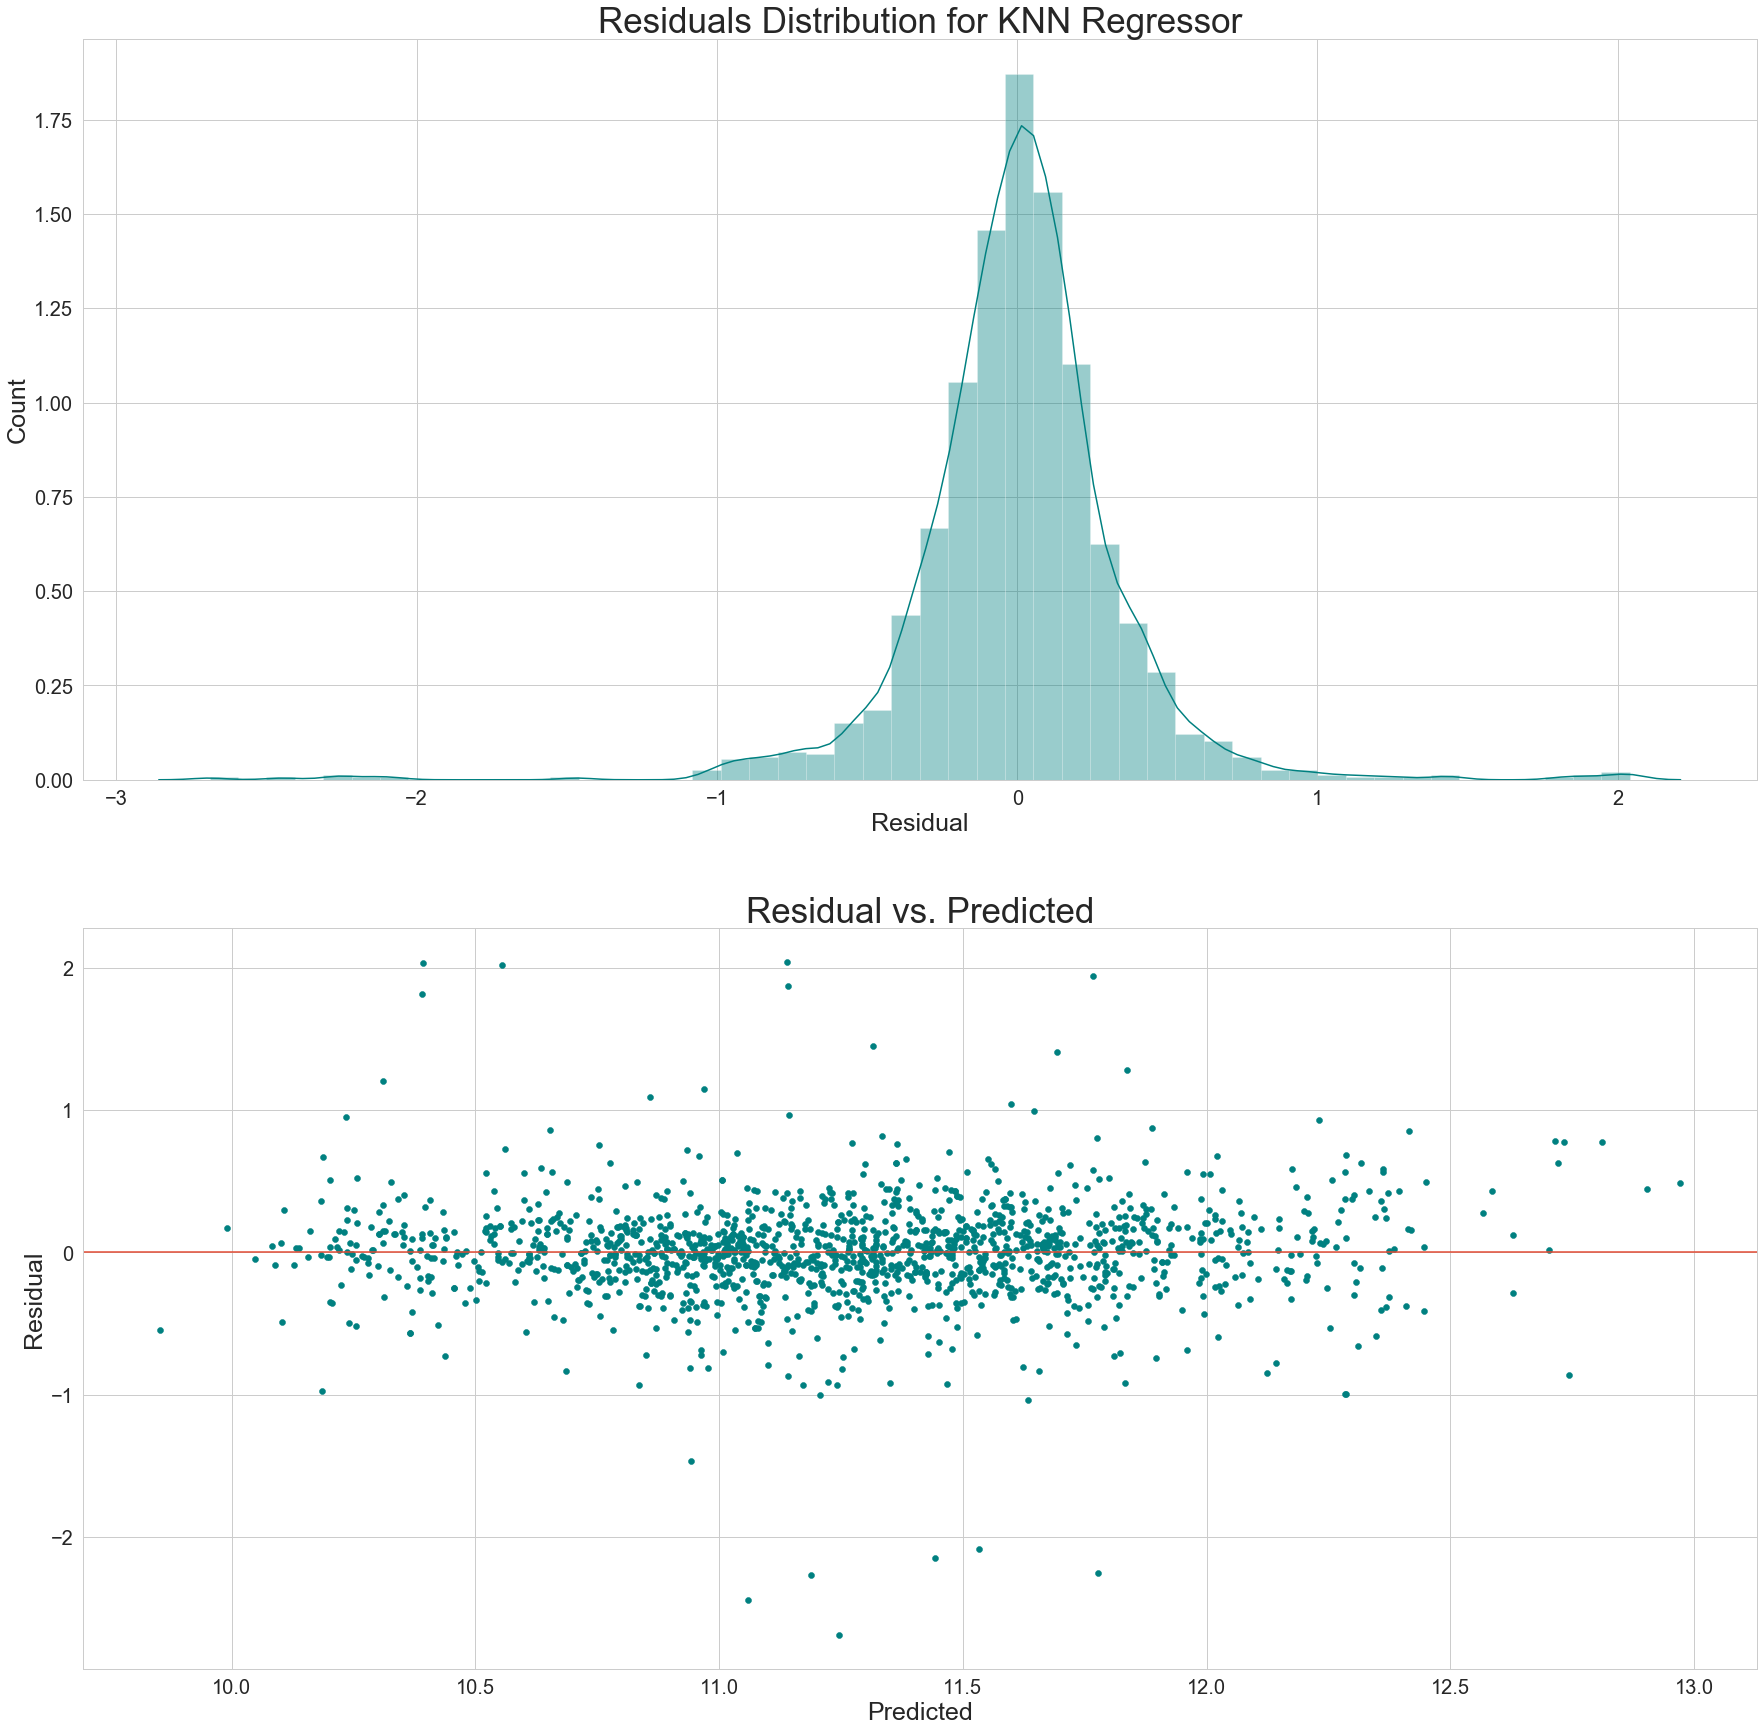

In [109]:
# plot the residuals 
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sb.distplot(knn_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residuals Distribution for KNN Regressor',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)
#residuals vs predicted
ax2 = plt.subplot(212)
plt.scatter(knn_preds, knn_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
plt.show()

The root mean square error stays the same when changing the number of values. Nothing to tune..

##### 4. Random Forrest Regressor

In [38]:
#create the RFR model 
rfr = RandomForestRegressor(n_estimators = 100, criterion = 'mse',max_depth =50, random_state = 3,n_jobs = -1)
#fit the model 
rfr.fit(X_train,y_train)
rfr_preds = rfr.predict(X_test)
# compute the residuals 
rfr_residuals = y_test - rfr_preds
# get the error and evaluate
rfr_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rfr_preds)))
rfr_r2 = r2_score(y_test, rfr_preds)
rfr_mape = MAPE(np.exp(y_test),np.exp(rfr_preds))
print('RMSE: %.2f'% rfr_rmse)
print('R2 Score: %.2f' % rfr_r2)
print('MAPE:%.2f' % rfr_mape)
# Values without log transformation  
#RMSE = 46505.90
#R2 =  0.65

RMSE: 44363.59
R2 Score: 0.74
MAPE:22.09


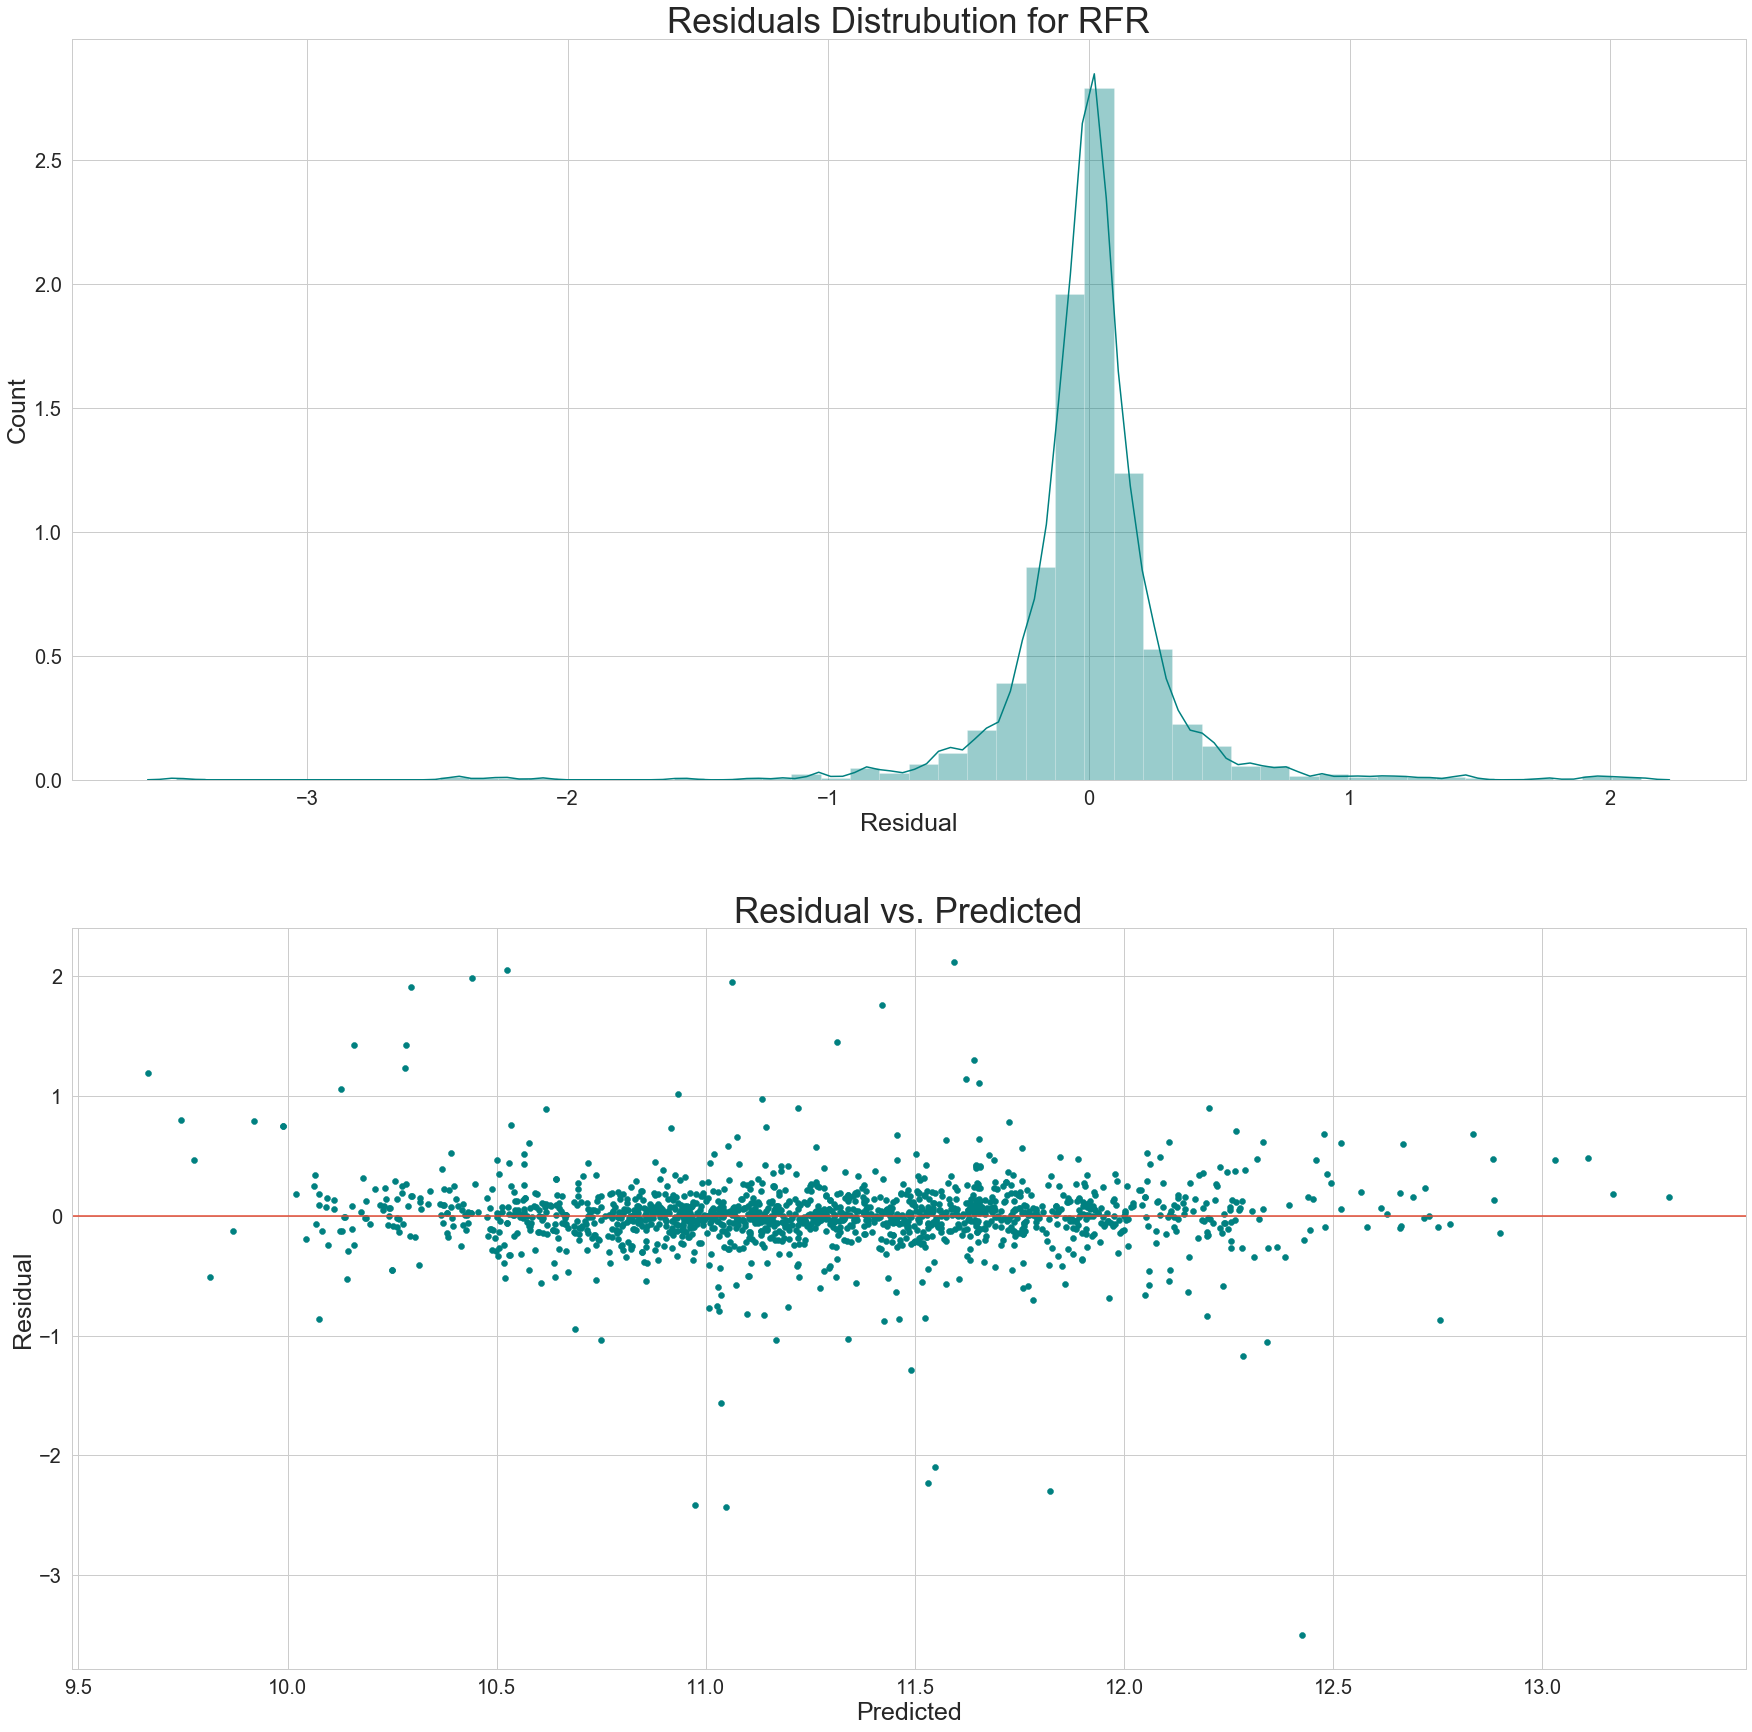

In [111]:
# plot the residuals 
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sb.distplot(rfr_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residuals Distrubution for RFR',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)
#residuals vs predicted
ax2 = plt.subplot(212)
plt.scatter(rfr_preds, rfr_residuals, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
plt.show()

1.production_year(0.497795)
2.mark(0.154525)
3.model(0.141983)
4.fuel_type(0.139483)
5.fiscal_power(0.066214)


<BarContainer object of 5 artists>

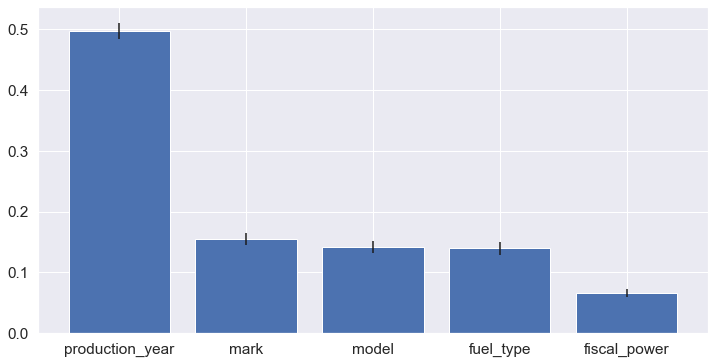

In [39]:
#show the feature importance list to the RFR Model
sb.set(font_scale=1.4)
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns)
importance_list = []
for f in range(X.shape[1]):
    feature = features[indices[f]]
    importance_list.append(feature)
    print("%d.%s(%f)" % (f + 1, feature, importances[indices[f]]))
#plot the important features 
plt.figure(figsize=(12,6))
#plt.title("Feature importances")
plt.bar(importance_list, importances[indices],color="b", yerr=std[indices])

##### 5. Gradient Boosting Regressor

In [114]:
%%time
#let's do some grid searching for parameters to potimize our model  
r_sqaures = []
depth = []
mean_scores = []

# you can try other loss functions : {‘ls’, ‘lad’, ‘huber’, ‘quantile’}
for i in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=i)
    gbr.fit (X, logy)
    depth.append(i)
    r_sqaures.append(gbr.score(X, logy))
    mean_scores.append(cross_val_score(gbr, X, logy, cv=12).mean())    

Wall time: 1min 8s


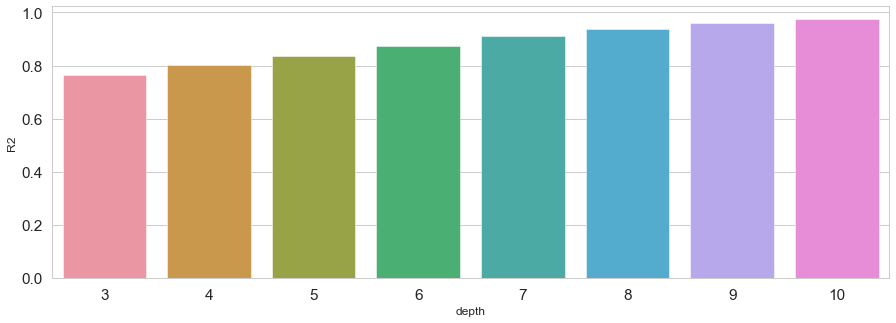

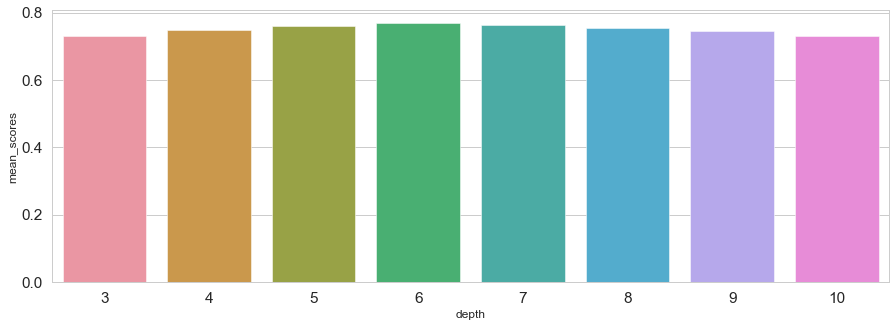

In [115]:
gbr_df = pd.DataFrame(data={'mean_scores':mean_scores,'depth':depth,'R2':r_sqaures})

#plot the results 
fig, ax = plt.subplots(figsize=(15, 5))
sb.barplot(data = gbr_df, x='depth', y='R2')
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sb.barplot(data = gbr_df, x='depth', y='mean_scores')
plt.show()

In [85]:
#as the plot show above the ultimate value for debpth parameter is 8
gbr = GradientBoostingRegressor(loss ='huber', max_depth=6)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)
gbr_residuals = y_test - gbr_preds
#evaluate 
gbr_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gbr_preds)))
gbr_r2 = r2_score(y_test,gbr_preds)
gbr_mape = MAPE(np.exp(y_test),np.exp(gbr_preds))
gbr_scores = cross_val_score(gbr, X, logy, cv=12)
#show results 
print('CV Mean Score: %.2f'%gbr_scores.mean())
print('RMSE: %.2f'%gbr_rmse)
print('R2 Score:  %.2f'%gbr_r2)
print('MAPE: %.2f'%gbr_mape)
# metrics  without log transformation 
# Cross Validation Mean Score: 0.62
#RMSE = 44328.43
#R2 Score =  0.68

CV Mean Score: 0.79
RMSE: 44267.49
R2 Score:  0.82
MAPE: 16.87


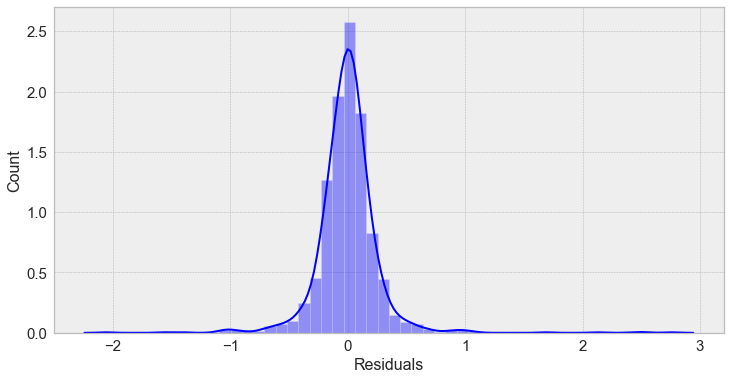

In [107]:
plt.style.use('bmh')
#sb.set(font_scale=1.4)
fig = plt.figure(figsize=(12,6))
sb.distplot(gbr_residuals, color ='blue')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.title('Normality Assumption')
plt.xlabel('Residuals',fontsize=16)
plt.ylabel('Count',fontsize=16)
fig.savefig('normality.jpg',dpi=500)

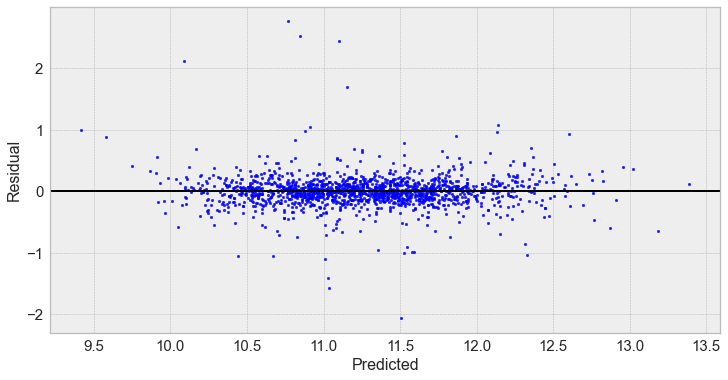

In [109]:
plt.style.use('bmh')
#sb.set(font_scale=1.4)
fig = plt.figure(figsize=(12,6))
plt.scatter(gbr_preds, gbr_residuals, color ='blue',alpha=0.9,s=6)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.title('Homoscedasticity Assumption')
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('Residual',fontsize=16)
plt.axhline(y=0)
plt.show()
fig.savefig('homoscadacity.jpg',dpi=500)

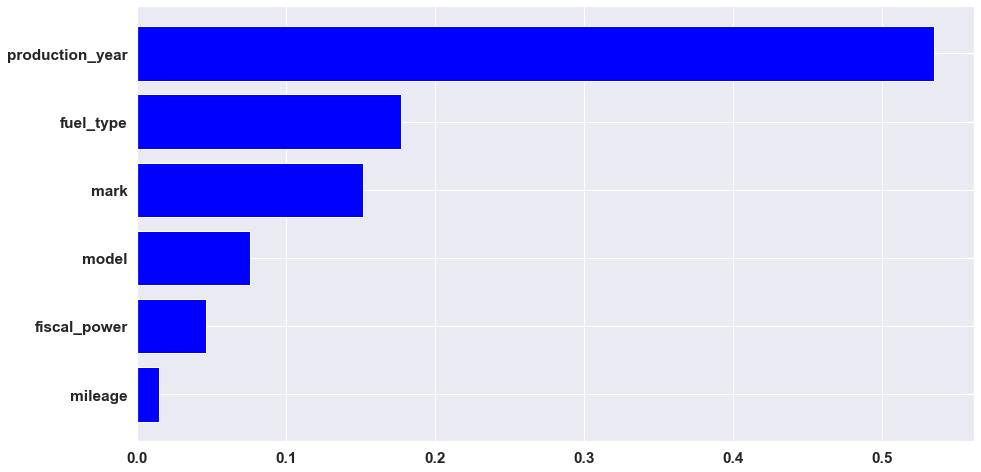

In [34]:
#plot features importance
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
sb.set(font_scale=1.4)
fig = plt.figure(figsize=(15,8))
sorted_idx = gbr.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], gbr.feature_importances_[sorted_idx],color='blue',)
#plt.title("GBR Feature Importance")
plt.show()
fig.savefig('images/gbr_importance.jpeg',dpi=600)

#### XGBoost Regressor

In [42]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
params = {"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4]}
model = GridSearchCV(
            estimator= xgb,
            param_grid= params,
            cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid  = model.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 3}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [43]:
#fit and predict and evaluate 
xgb = grid.best_estimator_
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_residuals = y_test - xgb_preds
#evaluate 
xgb_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gbr_preds)))
xgb_r2 = r2_score(y_test,xgb_preds)
xgb_mape = MAPE(np.exp(y_test),np.exp(xgb_preds))
#xgb_scores = cross_val_score(xgb, X, logy, cv=10,scoring=)
#show results 
#print('CV Mean Score: %.2f'%gbr_scores.mean())
print('RMSE: %.2f'%xgb_rmse)
print('R2 Score:  %.2f'%xgb_r2)
print('MAPE: %.2f' % xgb_mape)

RMSE: 43335.20
R2 Score:  0.78
MAPE: 20.12


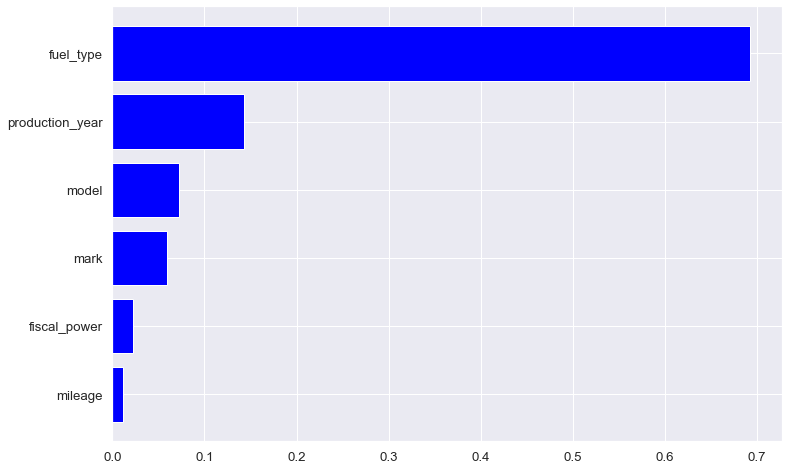

In [53]:
#plot features importance 
sb.set(font_scale=1.2)
fig = plt.figure(figsize=(12,8))
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx],color='blue')
#plt.xlabel("Xgboost Feature Importance")
plt.show()
fig.savefig('images/xgb_importance.jpeg',dpi=500)

#### Keras Model

In [78]:
 def build_model():
    ann = Sequential()
    ann.add(Dense(32, input_dim=6, activation='relu'))
    ann.add(Dense(16, activation='relu'))
    ann.add(Dense(8, activation='relu'))
    ann.add(Dense(1))
    # Compile model
    ann.compile(loss='mean_squared_error', optimizer='adam')
    return ann 
#fit the model 
keras_model = KerasRegressor(build_fn=build_model, epochs=50, batch_size=32, verbose=0)
history = keras_model.fit(X_train,y_train)

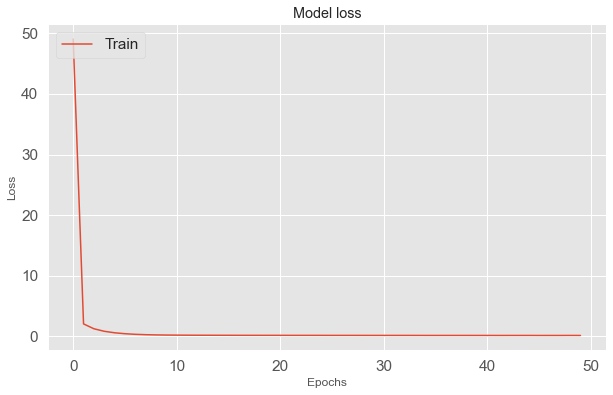

In [79]:
#Visualising loss function plot 
plt.figure(figsize=(10,6))
plt.style.use('ggplot')
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [80]:
#predict
ann_preds = keras_model.predict(X_test)
#get R squqred score for ANN
ann_r2 = r2_score(y_test,ann_preds)
#get RMSE error
ann_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(ann_preds)))
ann_mape = MAPE(np.exp(y_test),np.exp(ann_preds))
print("R2 score: ", round(ann_r2,2))
print("RMSE Error: ",round(ann_rmse,2))
print('MAPE:%.2f'% ann_mape)

R2 score:  0.66
RMSE Error:  54106.16
MAPE:27.83


##### 6. Results and Comparison

In [137]:
# For comparaison, let's put the results for all the models together in dataframe 
models = ['Linear Regressor','Random Forrest Regressor','KNN Rgressor',
          'Gradient Boosting Regressor','Keras ANN']
r2_scores = [lr_r2,rfr_r2,knn_r2,gbr_r2,ann_r2]
#round the scores
r2_scores = [round(i,2) for i in r2_scores]
rmses = [lr_rmse,rfr_rmse,knn_rmse,gbr_rmse,ann_rmse]
#round the errors
rmses = [round(i,2) for i in rmses]
results = pd.DataFrame(list(zip(models,r2_scores,rmses)),columns=['Model','R^2 Score','RMSE'])
results

,Model,R^2 Score,RMSE
0,Linear Regressor,0.57,63933.52
1,Random Forrest Regressor,0.74,44939.79
2,KNN Rgressor,0.70,51224.96
3,Gradient Boosting Regressor,0.78,44616.20
4,Keras ANN,0.67,54957.98


In [43]:
### to get the real predictions we reverse the transformation log by computing its expenential value
## put the real price values vs predicted values 
test_results = pd.DataFrame()
test_results['Price'] = np.exp(y_test)
test_results['Predicted Price'] = np.exp(gbr_preds)
#show 
test_results

,Price,Predicted Price
4321,75000.0,90644.867723
236,123000.0,152844.918044
6687,309000.0,78455.025589
7115,42000.0,47370.984746
1325,28000.0,28720.505553
...,...,...
3041,123500.0,115498.613882
4184,60000.0,55946.865170
6959,93000.0,86057.735316
6375,49500.0,50525.932478


In [144]:
len(y_test)

1553

In [141]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


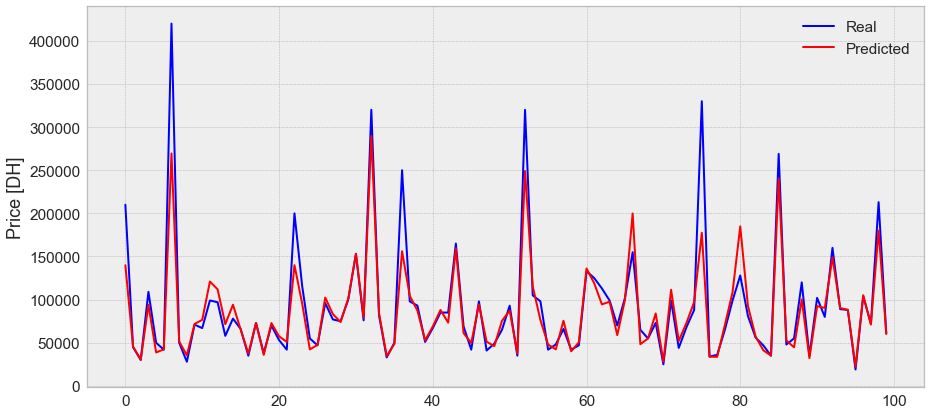

In [118]:
#plot the predicted values vs real values 
sb.set(font_scale=1.4)
plt.style.use('bmh')
A = np.array(np.exp(y_test)).reshape(-1, 1)
B = np.array(np.exp(gbr_preds)).reshape(-1, 1)
fig = plt.figure(figsize=(15,7))
plt.plot(A[-100:], label="Real",color='blue')
plt.plot(B[-100:], label="Predicted",color='red')
plt.legend()
#plt.title("Price: Real vs Predicted",fontsize=22)
plt.ylabel("Price [DH]",fontsize=18)
plt.show()
fig.savefig('results.jpg',dpi=600)

##### 7. Save Models 

In [162]:
#save Grandient Bossting Model 
with open("models/GBR_Model.pkl" , 'wb') as file:  
    pickle.dump(gbr, file)
#save Random Forrest Model 
with open("models/RFR_Model.pkl" , 'wb') as file:  
    pickle.dump(rfr, file)
print('Models Saved Sucessefully!')

Models Saved Sucessefully!
